# Neoclassical growth model in discrete time: stochastic case

###### First written: December 8, 2019

## Introduction

In this notebook, we discuss the following stochastic neoclassical growth model where the social planner maximizes his infinite time horizon utility subject to the budget constraint with full capital depreciation and the stochastic TFP shock:

\begin{align}
& \max \mathbb{E}_{0}\left[\sum_{t=0}^{\infty}\beta^{t}\ln \left(C_{t} -\psi N_{t}^{\theta}\right) \right]\\
\text{s.t.} \quad & K_{t+1} + C_{t} \leq A_{t}K_{t}^{\alpha} N_{t}^{1-\alpha} \\
& \ln{A_{t+1}} = \rho \ln{A_{t}} + \epsilon_{t+1}, \quad \epsilon_{t+1} \sim N\left(0, s^{2}\right)
\end{align}

The utility function follows the classical Greenwood–Hercowitz–Huffman preferences (Greenwood et al. (1988)), and the TFP shock follows the AR(1) process.

We know that if the model is deterministic, i.e., $A_{t} = 1, \forall t$, the above neoclassical growth model is well known to have a closed form solution:
\begin{align}
& K_{t+1} = \beta \alpha K_{t}^{\alpha} N_{t}^{1-\alpha} \\
& C_{t} = \left(1- \beta \alpha \right) K_{t}^{\alpha} N_{t}^{1-\alpha}
\end{align}

When we solve the stochastic growth model for its first-order conditions, we can derive the following two equilibrium condition:
\begin{align}
& \lambda_{t} - \beta \alpha \mathbb{E}_{t}\left[\lambda_{t+1} A_{t+1} K_{t+1}^{\alpha-1}N_{t+1}^{1-\alpha}\right] = 0\\
& A_{t} K_{t}^{\alpha}N_{t}^{1-\alpha} - C_{t} - K_{t+1} = 0
\end{align}
where $\lambda_{t}$ is the Lagrangian multiplier associated with the resource constraint.

Our aim here is to numerically solve the system of non-linear equations by the time iteration collocation with Gaussian process regression. As seen above, our model has two policy functions to be approximated. In this case, there are two ways:
- Develop a Gaussian process for each policy function and nest them in the model
- Develop the **coregionalized Gaussian process regression**
If both policy functions correlate well, the latter option seems to be appropriate.

Before diving into the coregionalized Gaussian process, we import some numerical libraries in python:

In [1]:
import sys
import warnings
import numpy as np
import pyipopt
import GPy
# plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
# Use TeX font
rc('font', **{'family': 'sans-serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 15

np.random.seed(0)

%matplotlib inline

where
- GPy: modeling the Gaussian process
- IPOPT: solving the system of non-linear equations.

We define economic parameters in following:

In [2]:
# --------------------------------------------------------------------------- #
# Parameter setting
# --------------------------------------------------------------------------- #
A_bar = 1  # The mean of the technology shock
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.95  # Discount factor
psi = 0.25  # Coefficient of leisure in the utility function
theta = 1.5  # Elasticity of leisure in the utility function

# AR(1) technology shock
rho = 0.95  # Autocorrelation coefficient
mu = 0  # Mean
s = 0.01  # Standard deviation

## Analytical solutions

As discussed above, the deterministic version of this model has a closed-form solution, in the following way:

In [3]:
# --------------------------------------------------------------------------- #
# Analytical solution
# --------------------------------------------------------------------------- #
def ls_compute(k, A=A_bar, alpha=alpha, psi=psi, theta=theta):
    """ Return the optimal labor supply """
    return (((1-alpha) * A * k**alpha) / (psi*theta))**(1 / (theta+alpha-1))


def kplus_compute_analytic(
        k, A=A_bar, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal capital stock in the next period """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return alpha * beta * A * k**alpha * _ls**(1-alpha)


def c_compute_analytic(
    k, A=A_bar, alpha=alpha, beta=beta, psi=psi, theta=theta):
    """ Analytical solution
    Return the optimal consumption policy """
    _ls = ls_compute(k, A, alpha, psi, theta)
    return (1 - alpha*beta)*A*k**alpha*_ls**(1-alpha)

## Time iteration collocation with the Gaussian process regression

### Discretization
Following Judd (1998), we use the Gauss-Hermite quadrature rule degree 5 to discretize the continuous AR(1) technology shock. The Gauss-Hermite nodes as well as the weights can be defined in the following way:

In [4]:
# Nodes
x5 = np.sqrt(2) * s * np.array(
    [2.020182870456086, 0.9585724646138185, 0, -0.9585724646138185,
     -2.020182870456086]) + mu
# Weights
omega5 = np.pi**(-1/2) * np.array(
    [0.01995324205904591, 0.3936193231522412, 0.9453087204829419,
     0.3936193231522412, 0.01995324205904591])

print("GH5 nodes are {}".format(x5))
print("GH5 weights are {}".format(omega5))

GH5 nodes are [ 0.0285697   0.01355626  0.         -0.01355626 -0.0285697 ]
GH5 weights are [0.01125741 0.22207592 0.53333333 0.22207592 0.01125741]


### Coregionalized Gaussian process regression

#### Define the training and test datasets as well as a multi output kernel
Firstly, we define the $2 \times 2$ state space $[\underline{K}, \overline{K}] \times [\underline{A}, \overline{A}]$. Note that input dimensions is **2** (capital and technology shock states) and the number of outputs is also **2** (capital stock in the next period and the Lagrange multiplier).

In [5]:
# --------------------------------------------------------------------------- #
# Set the exogenous capital domain
# Must include the certainty equivalent steady state
# --------------------------------------------------------------------------- #
kbeg, kend = 0.05, 0.2  # Capital state
abeg, aend = 0.8, 1.2  # AR(1) technology state

# --------------------------------------------------------------------------- #
# Gaussian process, training and test dataset
# --------------------------------------------------------------------------- #
num_train = 10  # Number of training samples
num_test = 1000  # Number of test samples
dim_input = 2  # Input dimension of the Gaussian process
num_output = 2  # Number of outputs in the coregionalization matrix

# Training datasets
X_train = np.random.uniform(
    [kbeg, abeg], [kend, aend], (num_train, dim_input))

# Test datasets, used to evaluate the approximation quality
X_test = np.random.uniform([kbeg, abeg], [kend, aend], (num_test, dim_input))

# --------------------------------------------------------------------------- #
# Initialize outputs
# Capital stock in the next period and the Lagrange multiplier
# --------------------------------------------------------------------------- #
def Y_train_guess(X):
    """ Initialize training outputs """
    k = X[:, 0][:, None]  # Capital stock state
    a = X[:, 1][:, None]  # Technology shock state
    _Y_train_kplus = k
    _Y_train_ls = ls_compute(k=k, A=a, alpha=alpha, psi=psi, theta=theta)
    _Y_train_c = a * k**alpha * _Y_train_ls**(1 - alpha) - _Y_train_kplus
    _Y_train_lambd = 1 / (_Y_train_c - psi * _Y_train_ls**theta)
    return _Y_train_kplus, _Y_train_lambd

# Initialize outputs
Y_train_kplus, Y_train_lambd = Y_train_guess(X_train)
assert X_train.shape == (num_train, dim_input), "Shape compatible error"
assert Y_train_kplus.shape == (num_train, 1), "Shape compatible error"
assert Y_train_lambd.shape == (num_train, 1), "Shape compatible error"

#### Multioutput kernel
Finally we construct a multi output kernel. We use the **Marten 5/2 kernel** and define a multi outputs kernel in the following way by using the built-in function `GPy.util.multioutput.ICM` to automate defining two kernels and multiplying two of them:

In [6]:
# --------------------------------------------------------------------------- #
# Instantiate and initialize the Gaussian process
# Use the GPy library and restart hyperparameters optimizations
# Coregionalized regression model
# --------------------------------------------------------------------------- #
# Define a multioutput kernel
kernel = GPy.kern.Matern52(input_dim=dim_input)
multikernel = GPy.util.multioutput.ICM(
    input_dim=dim_input, num_outputs=num_output, kernel=kernel)

# Instantiate and initialize the multioutput Gaussian process
gp = GPy.models.GPCoregionalizedRegression(
    X_list=[X_train, X_train],
    Y_list=[Y_train_kplus, Y_train_lambd], kernel=multikernel)
print("Before hyperparameters optimization")
print(gp)

# Fit to data using Maximum Likelihood Estimation of the parameters
n_restarts = 10
gp.optimize_restarts(n_restarts, verbose=False)
print("After hyperparameters optimization")
print(gp)

Before hyperparameters optimization

Name : gp
Objective : 25.725920797183413
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  gp.                                    |   value  |  constraints  |  priors
  ICM.Mat52.variance                     |     1.0  |      +ve      |        
  ICM.Mat52.lengthscale                  |     1.0  |      +ve      |        
  ICM.B.W                                |  (2, 1)  |               |        
  ICM.B.kappa                            |    (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |     1.0  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |     1.0  |      +ve      |        
After hyperparameters optimization

Name : gp
Objective : -15.869829183242391
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  gp.                                    |                   value  |  constraints  |  priors
  ICM.Mat52.variance    

In [11]:
# --------------------------------------------------------------------------- #
# Check the defined multioutput kernel works well or not
# --------------------------------------------------------------------------- #
X_check = np.random.uniform([kbeg, abeg], [kend, aend], (10, dim_input))
# If we are interested in the first output
X_check_kplus = np.hstack([X_check, np.ones_like(X_check[:, 1:]) * 0])
noise_dict_kplus = {'output_index': X_check_kplus[:, 2:].astype(int)}
print("Prediciton of the first output kplus")
print(gp.predict(X_check_kplus, Y_metadata=noise_dict_kplus)[0])

# If we are interested in the second output
X_check_lambd = np.hstack([X_check, np.ones_like(X_check[:, 1:]) * 1])
noise_dict_lambd = {'output_index': X_check_lambd[:, 2:].astype(int)}
print("Prediciton of the second output lambd")
print(gp.predict(X_check_lambd, Y_metadata=noise_dict_lambd))

Prediciton of the first output kplus
[[0.05617291]
 [0.15334855]
 [0.18997025]
 [0.16732794]
 [0.12952172]
 [0.17535578]
 [0.11657044]
 [0.1311196 ]
 [0.19092375]
 [0.18479698]]
Prediciton of the second output lambd
[[[10.50371777]
  [14.0953249 ]
  [ 5.30200934]
  [24.82144227]
  [13.95719674]
  [ 7.26098946]
  [20.04401216]
  [ 7.70450288]
  [ 7.78071179]
  [ 4.77584824]]

 [[ 1.0013565 ]
  [ 1.00109344]
  [ 1.00027401]
  [ 1.03912816]
  [ 1.00141401]
  [ 1.00015932]
  [ 1.00647531]
  [ 1.00001593]
  [ 1.00022629]
  [ 1.00114908]]]


#### Define the equilibrium conditions

The following equilibrium conditions consists of the Euler equation and the resource constraint. We use IPOPT (https://www.coin-or.org/Ipopt/documentation/) to solve the system of non-linear equations. I follow Ferris et al. (2005) to convert a non-linear optimization model to a complementarity format.

Michael C. Ferris, Steven P. Dirkse and Alexander Meeraus, Mathematical Programs with Equilibrium Constraints: Automatic Reformulation and Solution via Constrained Optimization, Frontiers in Applied General Equilibrium Modeling, 2005, DOI: 10.1017/CBO9780511614330.005

In [8]:
# --------------------------------------------------------------------------- #
# Equilibrium conditions
# --------------------------------------------------------------------------- #
def euler(x0, state, gp):
    """
    Set of non-linear equilibrium conditions to be solved by IPOPT
    x0: Starting values for the optimization
    state: Current state, state[0]: capital state and state[1]: AR(1) TFP shock
    gp: Coregionalized Gaussian process regression model
    x[0]: Capital stock in the next period
    x[1]: lambda, Lagrange multiplier associated with the budget constraint
    """
    k, a = state[0], state[1]  # Extract the current state

    nvar = 2  # Number of variables

    # All of plicies are assumed to be non-negative
    x_L = np.zeros(nvar, dtype=float)
    x_U = np.ones(nvar, dtype=float) * np.inf

    # AR(1) technology shock
    # x5 is the Gauss-Hermite nodes
    aplus = np.empty_like(x5, dtype=float)
    for epsilon_idx, epsilon_plus in enumerate(x5):
        aplus[epsilon_idx] = a**rho * np.exp(epsilon_plus)
        
    # Current labor supply
    ls = ls_compute(k=k, A=a, alpha=alpha, psi=psi, theta=theta)
    
    def con(x, ls):
        """ Consumption """
        assert len(x) == nvar
        return 1 / x[1] + psi*ls**theta

    def lambdplus(x):
        """ Return lambda (the Lagrange multiplier) in the next period
        Discretize AR(1) shock by the Gauss-Hermite quadrature degree 5
        """
        assert len(x) == nvar
        _lambdplus = np.empty_like(aplus)
        for aplus_idx, aplus_val in enumerate(aplus):
            # lambda is the second argument
            stateplus = np.array([[x[0], aplus_val, 1]])
            noise_dict = {'output_index': stateplus[:, 2:].astype(int)}
            _lambdplus[aplus_idx] = gp.predict(
                stateplus, Y_metadata=noise_dict)[0].ravel()
        return _lambdplus

    def lsplus(x):
        """ Labor supply in the next period
        Discretize AR(1) shock by the Gauss-Hermite quadrature degree 5
        """
        assert len(x) == nvar
        _lsplus = np.empty_like(aplus)
        for aplus_idx, aplus_val in enumerate(aplus):
            _lsplus[aplus_idx] = ls_compute(
                k=x[0], A=aplus_val, alpha=alpha, psi=psi, theta=theta)
        return _lsplus

    def eval_f(x):
        """ Dummy objective function """
        assert len(x) == nvar
        return 0

    def eval_grad_f(x):
        """ Gradient of the dummy objective function """
        assert len(x) == nvar
        grad_f = np.zeros(nvar, dtype=float)
        return grad_f

    ncon = nvar  # Number of constraints

    """ Complementarity constraints
    g0: Euler equation wrt. k_{t+1}
    g1: Resource constraint """

    g_L = np.zeros(ncon, dtype=float)
    g_U = g_L

    nnzj = int(nvar * ncon)  # Number of (possibly) non-zeros in Jacobian
    nnzh = int((nvar**2 - nvar) / 2 + nvar)  # Number of non-zeros in Hessian

    def eval_g(x):
        """ The system of non-linear equilibrium conditions """
        assert len(x) == nvar

        g0 = x[1] - np.sum(np.multiply(
            omega5,
            beta * alpha * lambdplus(x) * aplus * x[0]**(alpha-1) * lsplus(x)**(1-alpha)))
        g1 = a * k**alpha * ls**(1-alpha) - con(x, ls) - x[0]

        return np.array([g0, g1])

    def eval_jac_g(x, flag):
        """ Numerical approximation of the Jacobian of the system of
        non-linear equilibrium conditions
        Use the finite-difference-values option provided by IPOPT """
        assert len(x) == nvar

        row_idx = np.empty(nnzj, dtype=int)  # Row index
        col_idx = np.empty(nnzj, dtype=int)  # Column index

        # Jacobian matrix structure
        if flag:
            for i in range(ncon):
                for j in range(nvar):
                    row_idx[j + i * nvar] = i
                    col_idx[j + i * nvar] = j

            return (row_idx, col_idx)

    # ----------------------------------------------------------------------- #
    # Define a NLP model
    # ----------------------------------------------------------------------- #
    pyipopt.set_loglevel(0)  # Let IPOPT quite

    neoclassical = pyipopt.create(
        nvar, x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f,
        eval_g, eval_jac_g)
    neoclassical.str_option("linear_solver", "ma57")
    neoclassical.str_option(
        "jacobian_approximation", "finite-difference-values")
    neoclassical.str_option("hessian_approximation", "limited-memory")
    neoclassical.int_option("print_level", 1)

    xstar, zl, zu, constraint_multipliers, obj, status = neoclassical.solve(x0)

    if status != 0:
        warnings.warn(
            "IPOPT fails to solve the system of non-linear equations. "
            "Use the starting value as the solution instead.")
        xstar = x0
    return xstar

#### Time iteration collocation

In [9]:
# --------------------------------------------------------------------------- #
# Time iteration collocation
# --------------------------------------------------------------------------- #
def time_iter_gpr(num_train, dim_input, num_outputs):
    """
    Time iteration collocation with the Gaussian process regression
    num_train: Number of training examples
    dim_input: Dimension of inputs
    num_output: Number of outputs
    """
    num_iter = 100  # Number of time iterations
    epsilons = []  # Track the approximation error
    epsilon_tol = 1e-5  # Convergence tolrance

    # ----------------------------------------------------------------------- #
    # Generate a training dataset
    # ----------------------------------------------------------------------- #
    X_train = np.random.uniform(
        [kbeg, abeg], [kend, aend], (num_train, dim_input))
    Y_train_kplus, Y_train_lambd = Y_train_guess(X_train)

    # ----------------------------------------------------------------------- #
    # Instantiate and initialize the Gaussian process
    # ----------------------------------------------------------------------- #
    # Define a multioutput kernel, use Matern52 kernel
    kernel = GPy.kern.Matern52(input_dim=dim_input)
    multikernel = GPy.util.multioutput.ICM(
        input_dim=dim_input, num_outputs=num_output, kernel=kernel)

    # Instantiate and initialize the multioutput Gaussian process
    gp = GPy.models.GPCoregionalizedRegression(
        X_list=[X_train, X_train],
        Y_list=[Y_train_kplus, Y_train_lambd], kernel=multikernel)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    n_restarts = 10
    gp.optimize_restarts(n_restarts, verbose=False)
    
    # ----------------------------------------------------------------------- #
    # Time iteration collocation
    # ----------------------------------------------------------------------- #
    for n in range(1, num_iter+1):

        # Starting value retliving from the previous optimization
        x0 = np.stack(
            [Y_train_kplus.ravel(), Y_train_lambd.ravel()], axis=1)

        # Keep the optimal policies
        Y_train_kplus = np.empty((num_train, 1), dtype=float)
        Y_train_lambd = np.empty_like(Y_train_kplus)

        for idx, state in enumerate(X_train):
            # For each state, solve the system of non-linear equations
            xstar = euler(x0[idx, :], state, gp)
            # Track the optimal policies
            Y_train_kplus[idx, 0] = xstar[0]
            Y_train_lambd[idx, 0] = xstar[1]

        # sys.exit(0)
        # ------------------------------------------------------------------- #
        # Train the Gaussian process with the optimal policy
        # ------------------------------------------------------------------- #
        kernel_updated = GPy.kern.Matern52(input_dim=dim_input)
        multikernel_updated = GPy.util.multioutput.ICM(
            input_dim=dim_input, num_outputs=num_output, kernel=kernel_updated)

        # Instantiate and initialize the multioutput Gaussian process
        gp_updated = GPy.models.GPCoregionalizedRegression(
            X_list=[X_train, X_train],
            Y_list=[Y_train_kplus, Y_train_lambd], kernel=multikernel_updated)
        
        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp_updated.optimize_restarts(n_restarts, verbose=False)
        # sys.exit(0)
        
        # ------------------------------------------------------------------- #
        # Approximation error analysis
        # Update the policy functions for the next iteration
        # ------------------------------------------------------------------- #
        X_test_kplus = np.hstack([X_test, np.ones_like(X_test[:, 1:]) * 0])
        noise_dict_kplus = {'output_index': X_test_kplus[:, 2:].astype(int)}

        X_test_lambd = np.hstack([X_test, np.ones_like(X_test[:, 1:]) * 1])
        noise_dict_lambd = {'output_index': X_test_lambd[:, 2:].astype(int)}

        # Track the current approximation error
        epsilon = max(
            np.max(np.abs(
                gp.predict(X_test_kplus, Y_metadata=noise_dict_kplus)[0]
                - gp_updated.predict(
                    X_test_kplus, Y_metadata=noise_dict_kplus)[0])),
            np.max(np.abs(
                gp.predict(X_test_lambd, Y_metadata=noise_dict_lambd)[0]
                - gp_updated.predict(
                    X_test_lambd, Y_metadata=noise_dict_lambd)[0]))
            )
        epsilons.append(epsilon)  # Track the history of epsilon

        if n % 1 == 0:
            print('Iteration: {}, Approximation error: {:.3e}'.format(
                n, epsilons[-1]))

        if epsilons[-1] < epsilon_tol:
            # Terminate the time iteration and save the optimal surrogates
            gp_star = gp_updated
            print("Time iteration collocation is terminated successfuly with "
                  "{} iterations".format(n))
            break  # Terminate the iteration

        else:
            # Update the GP with the surrogates
            gp = gp_updated

    return epsilons, gp_star

## Initial results

### Convergence
Plot the convergence process.

In [10]:
# --------------------------------------------------------------------------- #
# num_train=25, dim_input=2, num_output=2
# --------------------------------------------------------------------------- #
epsilons, gp_star = time_iter_gpr(25, 2, 2)

 /home/takafumi/.pyenv/versions/anaconda3-5.3.1/envs/adapt/lib/python3.7/site-packages/ipykernel_launcher.py:130: UserWarning:IPOPT fails to solve the system of non-linear equations. Use the starting value as the solution instead.
 /home/takafumi/.pyenv/versions/anaconda3-5.3.1/envs/adapt/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning:invalid value encountered in double_scalars
 /home/takafumi/.pyenv/versions/anaconda3-5.3.1/envs/adapt/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:invalid value encountered in double_scalars


Iteration: 1, Approximation error: 6.514e+00
Iteration: 2, Approximation error: 2.547e+01
Iteration: 3, Approximation error: 1.371e+01
Iteration: 4, Approximation error: 8.914e+00
Iteration: 5, Approximation error: 3.822e+00
Iteration: 6, Approximation error: 1.329e+00
Iteration: 7, Approximation error: 3.942e-01
Iteration: 8, Approximation error: 2.443e-01
Iteration: 9, Approximation error: 2.217e-01
Iteration: 10, Approximation error: 1.818e-01
Iteration: 11, Approximation error: 1.420e-01
Iteration: 12, Approximation error: 7.981e-02
Iteration: 13, Approximation error: 3.823e-02
Iteration: 14, Approximation error: 1.684e-02
Iteration: 15, Approximation error: 7.190e-03
Iteration: 16, Approximation error: 2.869e-03
Iteration: 17, Approximation error: 1.064e-03
Iteration: 18, Approximation error: 3.456e-04
Iteration: 19, Approximation error: 1.453e-04
Iteration: 20, Approximation error: 7.422e-05
Iteration: 21, Approximation error: 3.887e-05
Iteration: 22, Approximation error: 2.572e-

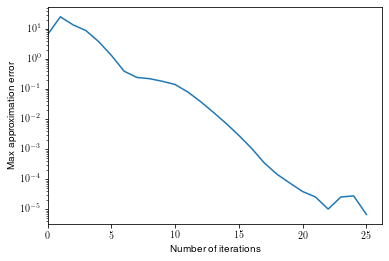

In [11]:
# --------------------------------------------------------------------------- #
# Plot an approximation error
# --------------------------------------------------------------------------- #
plt.plot(range(len(epsilons)), epsilons)
plt.yscale('log')
plt.xlabel("Number of iterations")
plt.ylabel("Max approximation error")
plt.xlim([0, None])
plt.show()

### Policy functions
Plot the policy functions.

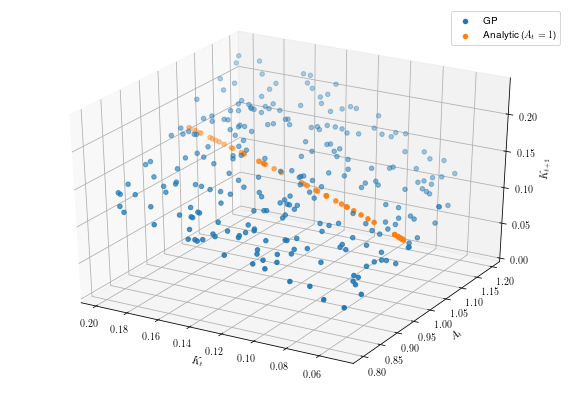

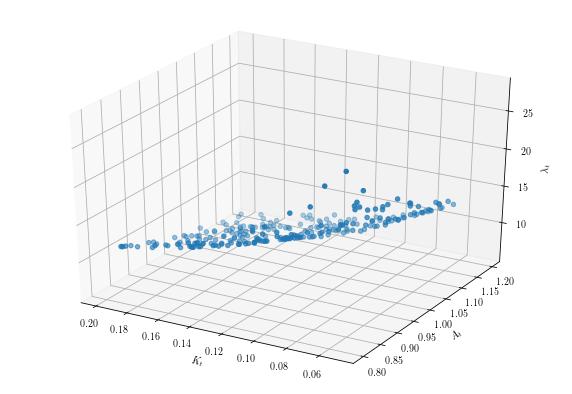

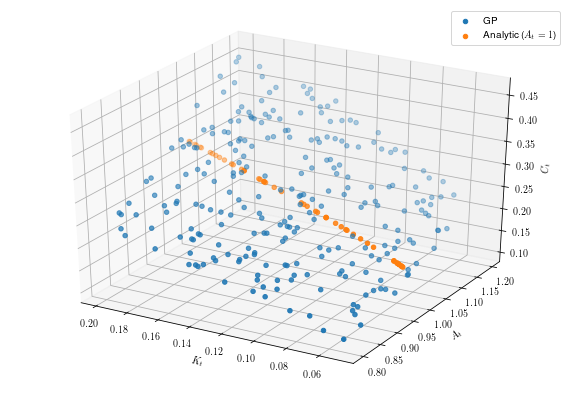

In [21]:
# --------------------------------------------------------------------------- #
# Plot approximated policy functions
# --------------------------------------------------------------------------- #
gridplt = np.random.uniform([kbeg, abeg], [kend, aend], (250, dim_input))
# Analytical solution when A = 1
gridplt_analytic = np.random.uniform([kbeg, 1], [kend, 1], (50, dim_input))

# Capital stock ------------------------------------------------------------- #
gridplt_kplus = np.hstack([gridplt, np.ones_like(gridplt[:, 1:]) * 0])
noise_dict_kplus = {'output_index': gridplt_kplus[:, 2:].astype(int)}
kplus_star = gp_star.predict(gridplt_kplus, Y_metadata=noise_dict_kplus)[0]
kplus_analytic = kplus_compute_analytic(gridplt_analytic[:, 0])

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(
    gridplt[:, 0], gridplt[:, 1], kplus_star.ravel(), 'o', label='GP')
ax.scatter(
    gridplt_analytic[:, 0], gridplt_analytic[:, 1], kplus_analytic, 'o',
    label='Analytic ($A_{t}=1$)')
ax.set_xlabel(r"$K_t$")
ax.set_ylabel(r"$A_t$")
ax.set_zlabel(r"$K_{t+1}$")
ax.set_zlim([0, None])
ax.invert_xaxis()
ax.legend(loc='best')
plt.show()

# Lambda -------------------------------------------------------------------- #
gridplt_lambd = np.hstack([gridplt, np.ones_like(gridplt[:, 1:]) * 1])
noise_dict_lambd = {'output_index': gridplt_lambd[:, 2:].astype(int)}
lambd_star = gp_star.predict(gridplt_lambd, Y_metadata=noise_dict_lambd)[0]

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(
    gridplt[:, 0], gridplt[:, 1], lambd_star.ravel(), 'o')
ax.set_xlabel(r"$K_t$")
ax.set_ylabel(r"$A_t$")
ax.set_zlabel(r"$\lambda_{t}$")
ax.invert_xaxis()
plt.show()

# Labor supply -------------------------------------------------------------- #
ls_star = ls_compute(
    gridplt[:, 0], gridplt[:, 1], alpha=alpha, psi=psi, theta=theta)

# Consumption --------------------------------------------------------------- #
c_star = 1 / lambd_star.ravel() + psi * ls_star**theta

c_star_analytic = c_compute_analytic(
    gridplt_analytic[:, 0], A=gridplt_analytic[:, 1], alpha=alpha, beta=beta, 
    psi=psi, theta=theta)

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(
    gridplt[:, 0], gridplt[:, 1], c_star, 'o', label='GP')
ax.scatter(
    gridplt_analytic[:, 0], gridplt_analytic[:, 1], c_star_analytic, 'o',
    label='Analytic ($A_{t}=1$)')
ax.set_xlabel(r"$K_t$")
ax.set_ylabel(r"$A_t$")
ax.set_zlabel(r"$C_{t}$")
ax.invert_xaxis()
ax.legend(loc='best')
plt.show()


### Mean and the standard deviation

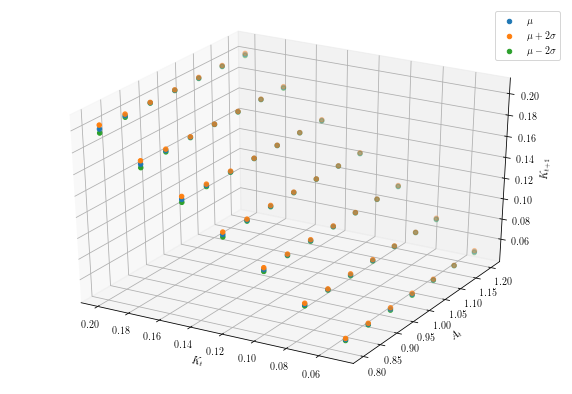

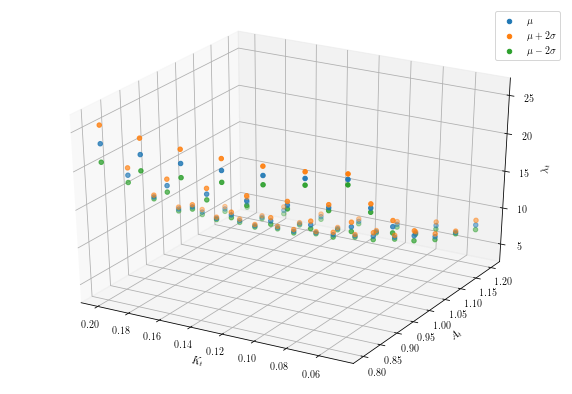

In [20]:
# 7x7 cartesian grid
cart_size = 7j
k_mgrid, a_mgrid = np.mgrid[kbeg:kend:cart_size, abeg:aend:cart_size]

# kplus
kplus_mu = np.empty_like(k_mgrid)
kplus_var = np.empty_like(k_mgrid)
# lambda
lambd_mu = np.empty_like(k_mgrid)
lambd_var = np.empty_like(k_mgrid)
for k_idx, k in enumerate(k_mgrid[:, 0]):
    for a_idx, a in enumerate(a_mgrid[0, :]):
        # kplus
        state = np.array([[k, a, 0]])
        noise_dict = {'output_index': state[:, 2:].astype(int)}
        kplus_mu[k_idx, a_idx] = gp.predict(state, Y_metadata=noise_dict)[0]
        kplus_var[k_idx, a_idx] = gp.predict(state, Y_metadata=noise_dict)[1]
        # lambda
        state = np.array([[k, a, 1]])
        noise_dict = {'output_index': state[:, 2:].astype(int)}
        lambd_mu[k_idx, a_idx] = gp.predict(state, Y_metadata=noise_dict)[0]
        lambd_var[k_idx, a_idx] = gp.predict(state, Y_metadata=noise_dict)[1]

# Standard deviation
kplus_sigma = np.sqrt(kplus_var)
lambd_sigma = np.sqrt(lambd_var)

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(
    k_mgrid, a_mgrid, kplus_mu, 'o', label=r'$\mu$')
ax.scatter(
    k_mgrid, a_mgrid, kplus_mu+2*kplus_sigma, 'o', label=r'$\mu + 2\sigma$')
ax.scatter(
    k_mgrid, a_mgrid, kplus_mu-2*kplus_sigma, 'o', label=r'$\mu - 2\sigma$')
ax.set_xlabel(r"$K_t$")
ax.set_ylabel(r"$A_t$")
ax.set_zlabel(r"$K_{t+1}$")
ax.invert_xaxis()
ax.legend(loc='best')

plt.show()

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': '3d'})
ax.scatter(
    k_mgrid, a_mgrid, lambd_mu, 'o', label=r'$\mu$')
ax.scatter(
    k_mgrid, a_mgrid, lambd_mu+2*lambd_sigma, 'o', label=r'$\mu + 2\sigma$')
ax.scatter(
    k_mgrid, a_mgrid, lambd_mu-2*lambd_sigma, 'o', label=r'$\mu - 2\sigma$')
ax.set_xlabel(r"$K_t$")
ax.set_ylabel(r"$A_t$")
ax.set_zlabel(r"$\lambda_{t}$")
ax.invert_xaxis()
ax.legend(loc='best')

plt.show()

We plot the predictive mean ($\mu$) as well as the point-wise predictive mean $\pm$ the two standard deviations ($\sigma$) of the approximated two policy functions. We train the model with randomly generated 25 training samples to construct the surrogates. As observed above, we can predict the optimal capital stock in the next period with very small confidence interval. The prediction of the Lagrange multiplier is somewhat poor. We need to train the model with the larger amount of training examples to achieve a better-fit.